#APOGEE Data:  "Zero to Hero"
TODO Add TOC
[Description](#Description)

Description
=============

### What this is

  An exectuable, interactive Ipython Notebook designed to quickly get
  novices up and running with APOGEE data. By the end of this tutorial,
  you will be able to :
  - Download the APOGEE Summary file
  - Read the APOGEE Summary file into memory
  - Define "clean" samples by making cuts on tageting and reduction
    flags
  - Make exciting plots of APOGEE data

  Along the way, you will also learn more about the APOGEE data model
  and bitmasks.


### What this isn't

  A comprehensive guide to the APOGEE survey and data products. Please
  see the official APOGEE documenation at
  [http://www.sdss.org/dr12/irspec/] for a more thorough understanding of
  the APOGEE database. Below, we provide links to this documentation
  where appropriate. [http://www.sdss.org/dr12/irspec/catalogs/] is the
  best place to start further educating yourself about APOGEE
  parameters. [Official papers?]




Sources/Thanks
================

  The material herein is a result of the whole APOGEE team.


Requirements
==============

  This tutorial is written in Python 2.7. Python 3+ *should* work with
  minimal effort from the user. Additional python modules required:
  - numpy
  - pyfits
  - matplotlib

  This notebook will likely still be valuable to you, but less so, if
  you are using a language other than python. There are official data
  exploration examples using the CAS database, IDL, or python at
  [http://www.sdss.org/dr12/irspec/catalogs/#ExamplesofselectingAPOGEEdatafromcatalogs]
  .



4 The Summary File
==================

  The APOGEE *allStar* summary file is one of two APOGEE [parameter catalogs](http://www.sdss.org/dr12/irspec/catalogs/) available as FITS tables. The entire summary parameter catalog is less than 1 GB in size, making it very portable and easy to access.
  The allStar file 
  >provides
  >information for each individual star observed in APOGEE-1, which
  >includes mean barycentric radial velocity, the standard deviation of
  >the mean velocity, ASPCAP parameters and abundances as derived from
  >the combined spectra, and a compilation of ancillary targeting data.
  
  >-[APOGEE official documentation](http://www.sdss.org/dr12/irspec/catalogs/)

  The latest, official Data Release from SDSS is DR12. The APOGEE summary
  file for this release is named 'allStar-v603.fits' (~683 MB). The rest of this tutorial will focus on interacting with this catalog.




5 Getting the Data
==================

  **Option 1**: Directly download the allStar file [HERE](http://data.sdss3.org/sas/dr12/apogee/spectro/redux/r5/allStar-v603.fits). Once the catalog is downloaded, move the file  into the path assigned to the `data_directory` variable in Section 6.2. The catalog is large (~683 MB) so it might be best to download the catalog first and then finish the tutorial.
  
  **Option 2**: Automatic Download. As you run the code, it will search for the *allStar-v603.fits* file in the path assigned to `data_directory`. If it is not found, the catalog will be downloaded.

##6 Loading the *allStar* Summary File

### 6.1 Python Preamble 
You need to press `Shift+Enter` to execute the code cells below. The preamble just contains some useful modules, functions, and plot formatting snippets. 

In [1]:
from __future__ import print_function
import numpy as np
import os
import sys
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

###Plot formatting commands
plt.rc('figure', figsize=(10.0, 7.1)) #bigger figures
plt.rc('xtick', labelsize=14)  #bigger labels
plt.rc('ytick', labelsize=14)
###End formatting commands


  
### Functions for automatic downloading of catalog
import urllib  
### Checking for python 2 or 3
if sys.version_info > (3,0): # If python3
    geturl_func = urllib.request.urlretrieve
else: #python2
    geturl_func = urllib.urlretrieve

#Progress bar function for automatic download (You can ignore this)
try:
    from IPython.html.widgets import FloatProgress
    from IPython.display import display
    from time import sleep
    progbar = FloatProgress(min=0, max=100, description='Download Progress...')
    html_widget = True
    def report(count, blockSize, totalSize):   #function to report download percentage
        percent = count*blockSize*100/float(totalSize)
        progbar.value = percent

except ImportError:
    html_widget = False
    from IPython.display import clear_output   #function to clear cell output
    def report(count, blockSize, totalSize):   #function to report download percentage
        percent = count*blockSize*100/float(totalSize)
        if (count % 100) ==0: #only update every 40 blocks 
            print('{0:.2f}'.format(percent), end=' ')

#clear_output()
#print('{}% complete\r'.format(percent))
#sys.stdout.flush()


:0: FutureWarning: IPython widgets are experimental and may change in the future.


### 6.2 APOGEE Data Path

   <span style="color:red">**MAKE SURE TO DEFINE YOUR DATA PATH in the next cell**</span>

  The `data_directory` variable is the diretory where your summary
  file is located OR where you want the summary file downloaded. Make sure this
  path exists on your local machine.

In [7]:
data_directory = "/Users/jquark/obs_data/apogee"  #### CHANGE THIS PATH

if not os.path.exists(data_directory):
    print("\nMake sure the data_directory path exists!\n")
else:
    print("Your APOGEE data directory is: {}\nWoohoo! Let's get started!".format(data_directory))


Your APOGEE data directory is: /Users/jquark/obs_data/apogee
Woohoo! Let's get started!


### 6.3 Reading the allStar File

The *allStar* file is a FITS table, a common astronomical data format. To read it off disk and into memory, we will use the popular [astropy](http://www.astropy.org/) package which includes the latest version of `pyfits` FITS reader. The code below will first try to use `astropy` but will automatically fall back to `pyfits` if `astropy` is not installed. At least one of these packages must be installed to continue. Note that  [pyfits](http://www.stsci.edu/institute/software_hardware/pyfits) is the precursor to the `astropy.io.fits` package.

In [8]:
try:
    import astropy.io.fits as pyfits
except ImportError:
    import pyfits

allStar_file = 'allStar-v603.fits'
allStar_localpath = os.path.join(data_directory,allStar_file)

allStar_file_link = "http://data.sdss3.org/sas/dr12/apogee/spectro/redux/r5/allStar-v603.fits"

#Download allStar file if it does not exist (This will take a while!)
if not os.path.exists(allStar_localpath):
    print ('% Complete: ', end=' ' )
    if html_widget:
        display(progbar)
    geturl_func(allStar_file_link, filename=allStar_localpath, reporthook=report)

try:
    allStar_fits = pyfits.open(allStar_localpath)
    allStar = allStar_fits[1].data #Takes data is HDU 1 and assigns it to allStar
except ValueError:
    print('FITS reader error: The catalog file is likely not complete.')
    print('Use the direct download link in Section 5 and copy file into the data_directory path.')

### 6.4 APOGEE *allStar* catalog as python variable


  The allStar variable is now a numpy
  record array, a wrapper around [numpy.ndarray](http://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html). The total number of stars in the catalog is equal to the number of rows in the table. Check the number of rows with 



In [9]:
allStar.shape

(163278,)

and the available data fields (This will print out every data field name in the `allStar` file)

In [10]:
allStar.dtype.fields

<dictproxy {'AK_TARG': (dtype('>f4'), 2005),
 'AK_TARG_METHOD': (dtype('S17'), 2009),
 'AK_WISE': (dtype('>f4'), 2026),
 'ALL_VISITS': (dtype('S737'), 2066),
 'ALL_VISIT_PK': (dtype(('>i4', (50,))), 3468),
 'AL_H': (dtype('>f4'), 1603),
 'AL_H_ERR': (dtype('>f4'), 1663),
 'AL_H_FLAG': (dtype('>i4'), 1723),
 'ANDFLAG': (dtype('>i4'), 524),
 'ANDFLAGS': (dtype('S59'), 528),
 'APOGEE_ID': (dtype('S18'), 157),
 'APOGEE_TARGET1': (dtype('>i4'), 257),
 'APOGEE_TARGET2': (dtype('>i4'), 261),
 'APSTAR_ID': (dtype('S45'), 0),
 'APSTAR_VERSION': (dtype('S5'), 675),
 'ASPCAPFLAG': (dtype('>i4'), 1418),
 'ASPCAPFLAGS': (dtype('S153'), 1422),
 'ASPCAP_CHI2': (dtype('>f4'), 1412),
 'ASPCAP_CLASS': (dtype('S2'), 1416),
 'ASPCAP_ID': (dtype('S44'), 79),
 'ASPCAP_VERSION': (dtype('S6'), 680),
 'CA_H': (dtype('>f4'), 1607),
 'CA_H_ERR': (dtype('>f4'), 1667),
 'CA_H_FLAG': (dtype('>i4'), 1727),
 'CHI2_THRESHOLD': (dtype(('>f4', (2,))), 659),
 'COMMISS': (dtype('>i2'), 385),
 'C_H': (dtype('>f4'), 1611),


7 *allStar* Data Model
=================================

A lot of your interaction with the APOGEE catalog will be through pulling out the information that interests you from the `allStar` file. It's a good idea to familiarize yourself with the catalog's contents.

The APOGEE team provides a full description of the *allStar* file via the [data model](http://data.sdss3.org/datamodel/files/APOGEE_REDUX/APRED_VERS/APSTAR_VERS/ASPCAP_VERS/RESULTS_VERS/allStar.html). Some details, like the size of the catalog on disk, will likely be different than v603 (the version you downloaded).
 
 A non-exhaustive list of important fields (some of which we will use below):

| Field          | dtype    | units     | description                                                                                                                             |
| ---            | ----     | ----      | ----                                                                                                                                    |
| APSTAR_ID      | char[37] |           | Unique apStar identifier: apogee.[ns].[sc].APSTAR_VERS.LOC.STAR, where [ns] is for APOGEE North/South, [sc] is for survey/commissioning |
| ASPCAP_ID      | char[36] |           | Unique ASPCAP identifier: apogee.[ns].[sc].RESULTS_VERS.LOC.STAR                                                                        |
| APOGEE_ID      | char[18] |           | TMASS-STYLE object name                                                                                                                 |
| J              | float32  |           | 2MASS J mag                                                                                                                             |
| H              | float32  |           | 2MASS H mag                                                                                                                             |
| K              | float32  |           | 2MASS Ks                                                                                                                                |
| GLON           | float64  | degrees   | Galactic                                                                                                                                |
| GLAT           | float64  | degrees   | Galactic                                                                                                                                |
| AK_TARG        | float32  |           | K-band extinction adopted for                                                                                                           |
| APOGEE_TARGET1 | int32    |           | first APOGEE target flag, see bitmask definitions                                                                                       |
| APOGEE_TARGET2 | int32    |           | second APOGEE target flag, see bitmask                                                                                                  |
| COMMISS        | int16    |           | =1 for commissioning data (before July 2011), else 0                                                                                    |
| SNR            | float32  |           | median S/N per pixel in combined frame (at apStar sampling                                                                              |
| STARFLAG       | int32    |           | Flag for star condition taken from bitwise OR of individual visits, see bitmask                                                         |
| VHELIO_AVG     | float32  | km/s      | average radial velocity, weighted by S/N, using RVs determined from cross-correlation of individual spectra with combined               |
| VSCATTER       | float32  | km/s      | scatter of individual visit RVs around                                                                                                  |
| TEFF           | float32  | K         | Teff from ASPCAP analysis of combined spectrum (from PARAM)                                                                             |
| LOGG           | float32  | log (cgs) | log g from ASPCAP analysis of combined spectrum (from PARAM)                                                                            |
| METALS         | float32  | dex       | [Z/H] from ASPCAP analysis of combined spectrum (from PARAM)                                                                            |
| ALPHAFE        | float32  | dex       | [alpha/Fe] from ASPCAP analysis of combined spectrum (from PARAM)                                                                       |
| ASPCAPFLAG     | int32    |           | Flag for  ASPCAP analysis, see bitmask                                                                                                  |
| PARAMFLAG      | int32[7] |           | Individual parameter flag for ASPCAP analysis, see bitmask                                                                              |


7.1 Sky map of the APOGEE Catalog
-----------------------------------

  Now that you have loaded the catalog, we can make our first plot! Let's make a sky map of the APOGEE catalog.

  - Maybe mention Kepler field here
  - Need to ask Gail about her plots



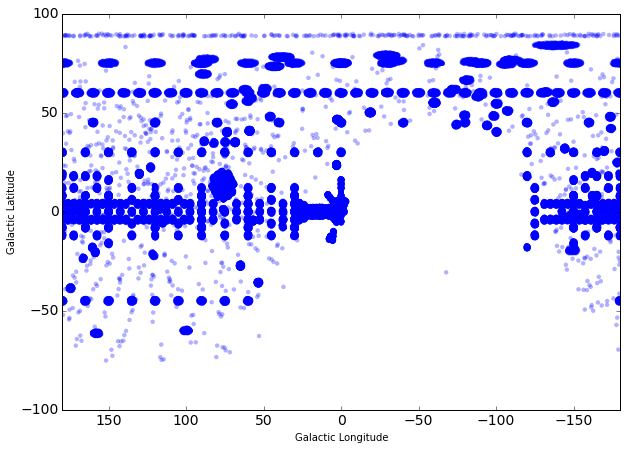

In [11]:
fig =plt.figure()
ax = plt.subplot(111) ## Ask Gail how she does the box around the projection, projection='mollweide') # set up projection
# For pretty plotting, make longitude negative relative to Galactic center.␣
l_corr_inds = allStar['GLON']>180 #indices for GLON correction
l_corr = allStar['GLON'].copy() # just to be safe,
l_corr[l_corr_inds] -=360
ax.scatter(l_corr, allStar['GLAT'], edgecolor='none', alpha=0.3)
ax.set_xlim(180,-180)
ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')

8 Clean samples, Targeting / Reduction flags
============================================

  Before doing any science with APOGEE, you will likely want a "clean"
  sample of stars. APOGEE has many special types of targets (calibration
  clusters, commissioning data, etc.; you can read more about the types
  of targets HERE). Below, we assume that you are interested in the
  "main" survey targets (defined below).


### 8.1 A Quick Aside: Bitmasks


  If you are unfamiliar with bitmasks, SDSS has published a great
  primer: [http://www.sdss.org/dr12/algorithms/bitmasks]. In short,
  bitmasks provide an easy way to ask many True/False questions about an
  object without the need for independent variables. Let's look at a
  quick example.
  


In [12]:
allStar['APOGEE_TARGET1'][2]

-2147481600

Above is the APOGEE_TARGET1 bitmask for a single star. A
  full description of the available bits in APOGEE_TARGET1 is available
  at [http://www.sdss.org/dr12/algorithms/bitmasks/#APOGEE_TARGET1].

  Each bit in the bitmask above contains information about the target. Note that all valid APOGEE targets have the 31st bit set.

This object is part of a 'short' cohort (see Zasowski+ for
  description), so the 11th bit is also set. You can check the value of a particular bit using the bitwise `and` operator.

In [13]:
allStar['APOGEE_TARGET1'][2] & 2**11

2048

The result will be non-zero if the bit is set; otherwise it will be zero.

In [14]:
allStar['APOGEE_TARGET1'][2] & 2**15 #not set

0

Below, we will be using a series of cuts on the APOGEE bitmasks to define our
  "clean" sample. 

  Links to other APOGEE bitmasks that we will use can be found at:
  [http://www.sdss.org/dr12/algorithms/bitmasks/#APOGEE_TARGET2]
  [http://www.sdss.org/dr12/algorithms/bitmasks/#APOGEE_ASPCAPFLAG]



### Defining the "Main" Sample

The `allStar` catalog contains all of the targets observed by the APOGEE survey, including engineering and calibration targets. Most scientific analysis will only use the 'main survey' targets as the parent sample of stars; the [APOGEE_EXTRATARG](http://www.sdss.org/dr12/algorithms/bitmasks/#APOGEE_EXTRATARG) bitmask (new in DR12) was specifically made for this purpose. The table below describes this bitmask.

|Bit Name	|Binary Digit|	Description|
|--
|NOT_MAIN	|0|	Not main survey target|
|COMMISSIONING	|1|	Commissioning data|
|TELLURIC	|2|	Telluric target|
|APO1M	|3|	1m observation|
|DUPLICATE	|4|	Duplicate observation|

Full descriptions of these terms can be found in the online [APOGEE targeting documentation](http://www.sdss.org/dr12/irspec/targets/) and the APOGEE target selection paper ([Zasowski et al. 2013](http://arXiv.org/abs/1308.0351)). If none of the bits in `EXTRATARG` are set, the target is part of the 'main survey' sample.

In [15]:
mainIndx = allStar['EXTRATARG'] == 0  #If the bitmask is 0, no bits are set

In [16]:
mainIndx # show what mainIndx actually is

array([False, False, False, ...,  True,  True, False], dtype=bool)

`mainIndx` is a [boolean index array](http://docs.scipy.org/doc/numpy/user/basics.indexing.html#boolean-or-mask-index-arrays). It has the same shape as the condition from which it was made (in this case, `allStar['EXTRATARG']` which has the same length as the other fields in the `allStar` table). The elements of `mainIndx` are true when `EXTRATARG`==0; else false. Boolean indices are a common way to select a subset of an data structure and we will encounter them in the rest of the tutorial.

In [17]:
np.sum(mainIndx) #True=1 and False=0; sum gives us the number of Main survey targets in DR12

108324

Let's define a new variable to point towards all of the 'Main' targets in the APOGEE catalog.

In [18]:
mainStar = allStar[mainIndx] #mainStar is now the main survey subsample

9 Plot: The RV distribution of the inner galaxy
==========================================================

Now that our main sample is defined, let's make some plots! First up, the line of sight velocity distribution for stars in sightlines towards the Galactic center.

Step one is to define the spatial region of interest and then grab the subset of targets meeting the conditions. Here, let's pick all stars with
    $-15^{\circ} < l < 15^{\circ}$ and close to the plane of the disk: $-5^{\circ} < b < 5^{\circ}$. Remember, the galactic longitude reported by APOGEE in the `GLON` field is in the range [$0^{\circ}$, $360^{\circ}$].


In [19]:
glon_gt_345 = mainStar['GLON']>345.0  #l > 345 (or > -15)
glon_lt_15 = mainStar['GLON']<15.0  #l < 15
glat_in_plane = np.abs(mainStar['GLAT'])< 5 # |b| < 5

Boolean arrays can be combined in many ways (below, we use [`numpy` logical operators]( functionshttp://docs.scipy.org/doc/numpy/reference/routines.logic.html#logical-operations)). In this case, we want stars that satisfy either of the longitude constraints and the latitude constraint.

In [20]:
inner_galaxy_stars = np.logical_and(np.logical_or(glon_gt_345, glon_lt_15), glat_in_plane)

In [21]:
inner_galaxy_stars  #Shows that inner_galaxy_mask is just another boolean mask

array([False, False, False, ..., False, False, False], dtype=bool)

In [22]:
inner_galaxy_stars.shape #with the same number of elements as mainStar

(108324,)

 We can check for the number of stars that our criteria by asking
  for the sum of the mask (remember: True=1 and False=0).

In [23]:
print('There are {0} main survey stars in our inner Galaxy region'.format(np.sum(inner_galaxy_stars)))

There are 7321 main survey stars in our inner Galaxy region


Boolean index arrays do not need to be assigned to variables to be combined. A shortcut to making the `inner_galaxy_stars` mask would be

In [24]:
inner_galaxy_stars2 = np.logical_and(np.logical_or(mainStar['GLON']>345.0, mainStar['GLON']<15.0), np.abs(mainStar['GLAT'])< 5)

In [25]:
(inner_galaxy_stars2 == inner_galaxy_stars).all() 
#check if all the elements of one array equal another

True

Now let's look at the distribution of radial velocities for main
  survey targets towards the inner galaxy. Below, we use the `matplotlib` histogram function [`hist`](http://matplotlib.org/api/pyplot_api.html).

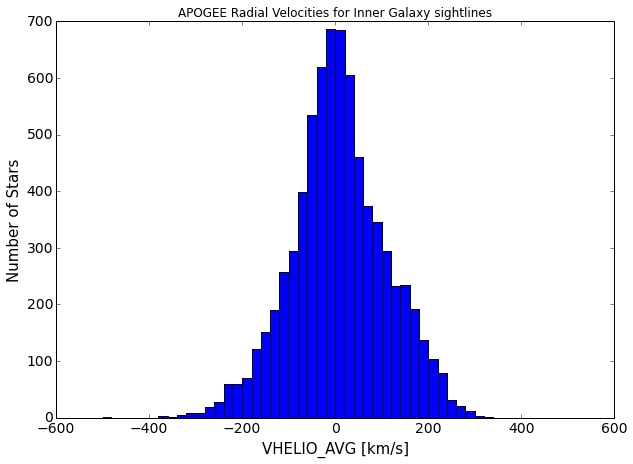

In [26]:
plt.figure() #make figure
plt.hist(mainStar[inner_galaxy_stars]['VHELIO_AVG'], bins = np.arange(-500,500,20))
#mainStar[inner_galaxy_stars] returns only mainStar entries with a True value in inner_galaxy_stars
plt.xlabel('VHELIO_AVG [km/s]', fontsize=15)
plt.ylabel('Number of Stars', fontsize=15)
plt.title('APOGEE Radial Velocities for Inner Galaxy sightlines')



  Beautiful! We find a sharp peak at VHELIO_AVG~ 0 km/s because many
  stellar orbits are perpendicular to our line of sight when we look
  towards the Galactic center. The positive skew is likely the result of an asymmetric distribution of Galactic longitude for our `inner_galaxy_stars`. The 4th quadrant ($270^{\circ} < l < 360^{\circ}$) of the Galaxy is less accessible from the Northern hemisphere. Our coverage of this area of the Galaxy will greatly improve in APOGEE-2. 

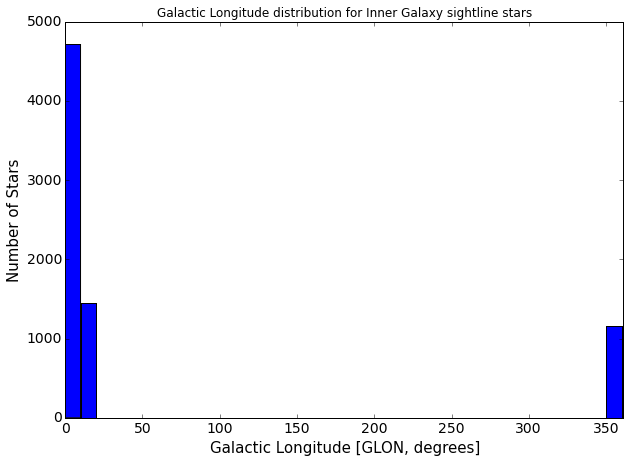

In [27]:
plt.figure() #make figure
plt.hist(mainStar[inner_galaxy_stars]['GLON'], bins = np.arange(0,361,10))
#mainStar[inner_galaxy_stars] returns only mainStar entries with a True value in inner_galaxy_stars
plt.xlabel('Galactic Longitude [GLON, degrees]', fontsize=15)
plt.ylabel('Number of Stars', fontsize=15)
plt.xlim(0,361)
plt.title('Galactic Longitude distribution for Inner Galaxy sightline stars')

Sure enough, the longitude distribution is heavily skewed towards stars at $0^{\circ} < l < 15^{\circ}$.

10 Galactic Plane Metallicity Maps
=========================
 

  This next plot is loosely based on the kinematics maps from Ness et al., in prep. (2015). Here we will map the metallicity of the Galaxy as a function of sky position, narrowing our analysis to $l<180^{\circ}$ sightlines in the Galactic plane.

We need to divide stars into 2-D position bins (using `GLON` and `GLAT`) and then compute the mean metallicity of all the stars in each bin. Conveniently, `matplotlib` provides a convenience function for this type of exploration: `hexbin` returns
  
> a hexagonal binning plot of x versus y, where x, y are 1-D sequenc
es of the same length, N. If C is None (the default), this is a histogram of
the number of occurences of the observations at (x[i],y[i]).  
> \- [`matplotlib` API](http://matplotlib.org/api/pyplot_api.html)
 


In [28]:
#define our zone of spatial interest and assign subset to variable
galactic_plane_stars = np.logical_and(mainStar['GLON']<180.0,np.abs(mainStar['GLAT'])< 15)
planeStar = mainStar[galactic_plane_stars] # planeStar now points to all the mainStar entries that are galactic_plane_stars.

In [29]:
print('{0} stars are "galactic_plane_stars"'.format(planeStar.shape[0])) 

52606 stars are "galactic_plane_stars"


Now we can use `hexbin` to plot the mean metallicity of stars as a function of position in the sky.

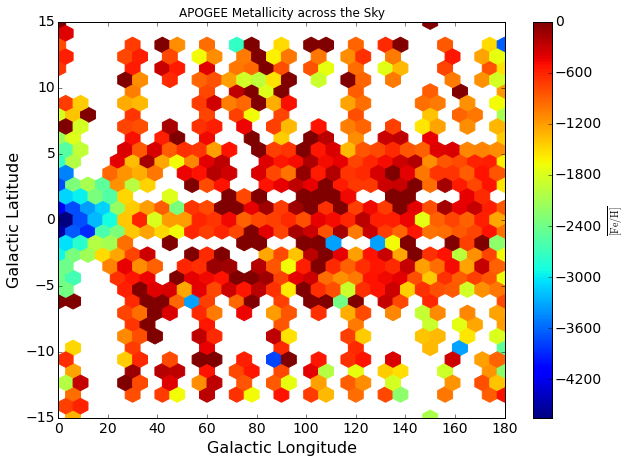

In [30]:
plt.figure()
plt.hexbin(planeStar['GLON'], planeStar['GLAT'], C=planeStar['FE_H'], gridsize=30, mincnt=2)
#Adding the 'C' keyword makes hexbin return the mean of the array for stars in each bin
#See http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.hexbin for options
plt.xlabel('Galactic Longitude', fontsize=16)
plt.ylabel('Galactic Latitude', fontsize=16)
cb = plt.colorbar(label=r'$\overline{[\mathrm{Fe/H}]}$')
#Label Colorbar
plt.title('APOGEE Metallicity across the Sky')

The hexagons above are colored by the mean metallicity of all the stars that have the labeled Galactic longitude and latitude. But, **WHAT HAPPENED?** The range of the colorbar suggests that many patches of the sky have a strongly negative iron abundance. How could the mean metallicity of some regions be ~-5000? This is out first plot using the chemical abundance data in the `allStar` catalog. Before we publish our miraculously discovery, we should make sure that the reduction and ASPCAP pipeline does not report any errors for these stars. 

After this tutorial, you should read [Using APOGEE Stellar Abundances](http://www.sdss.org/dr12/irspec/abundances/) before proceeding with your own science. Heed the warning at the top of page
>ASPCAP results should not be used blindly. They are provided with the general caveats that affect abundances determined spectroscopically under the standard assumption. Users are encouraged to thoroughly examine both the detectability and quality of the spectral features employed in the derivation of the desired element abundances. 

To ensure our chemical abundance results are robust, we should only use stars that:

 - are not commissioning targets. The commissioning data contain odd spectra that may not produce reliable stellar parameters (we have already done this by selecting only main survey targets).
 - had no issues reported with their parameter determination. The 'STAR_BAD' bit (bit 23) of the [ASPCAPFLAG bitmask](http://www.sdss.org/dr12/algorithms/bitmasks/#APOGEE_ASPCAPFLAG) is a catch-all bit designed to be set if ASPCAP returns an error during processing.
 - had no issues reported during the specific individual element determination. Specifically, we need to check if the 'GRIDEDGE_BAD' (bit 0), 'CALRANGE_BAD' (bit 1), and 'CALRANGE_WARN' (bit 9) are set in the [individual element bitmask](http://www.sdss.org/dr12/algorithms/bitmasks/#APOGEE_PARAMFLAG). See [ASPCAP Element Bitmasks](http://www.sdss.org/dr12/irspec/abundances/#ASPCAPElementBitmasks) for a description of these bits or other important caveats.

In [31]:
#We could build up the abundance masks using planeStar
#But let's check the abundance pipeline for all main survey targets via mainStar

stargood = mainStar['ASPCAPFLAG'] & 2**23 == 0 #True if STAR_BAD is NOT set
gridedge_good = mainStar['FE_H_FLAG'] & 2**0 == 0 #True if GRIDEDGE_BAD is NOT set
calrange_good = mainStar['FE_H_FLAG'] & 2**1 == 0 #True if CALRANGE_BAD is NOT set 
calrange_nowarn = mainStar['FE_H_FLAG'] & 2**9 == 0 #True if CALRANGE_WARN is NOT set 

#Want a combined index that returns stars that meet all of the above criteria
fehflag_good = np.logical_and.reduce((gridedge_good,calrange_good,calrange_nowarn))

#reduce lets us apply the logical_and to all arrays at once
#See http://docs.scipy.org/doc/numpy/reference/generated/numpy.ufunc.reduce.html for further reading

feh_robust = np.logical_and(stargood, fehflag_good)
#feh_robust is True only when all none of the abundance error bits are set

By applying these essential quality control cuts on the data, we will lose stars from our sample by defintion. Let's see what the numbers are...

In [32]:
print('The allStar file contains {0} entries'.format(allStar.shape[0]))
print('{0} of which are main survey targets'.format(mainStar.shape[0]))
print('{0} of {1} main stars do not have STAR_BAD set'.format(np.sum(stargood),mainStar.shape[0]))
print('{0} of {1} main stars report no individual FE abundance errors'.format(np.sum(fehflag_good),mainStar.shape[0]))
print('{0} of {1} main stars report no parameter errors and no individual [Fe/H] abundance errors'.format(np.sum(feh_robust),mainStar.shape[0]))


The allStar file contains 163278 entries
108324 of which are main survey targets
101235 of 108324 main stars do not have STAR_BAD set
82520 of 108324 main stars report no individual FE abundance errors
78284 of 108324 main stars report no parameter errors and no individual [Fe/H] abundance errors


In [33]:
#Now define sample is all inner_galaxy stars that ALSO meet the pipeline criteria
goodPlaneStar = mainStar[np.logical_and(galactic_plane_stars,feh_robust)]

In [34]:
print('{0} stars are "galactic_plane_stars" with robust [Fe/H] determination'.format(goodPlaneStar.shape[0]))

41035 stars are "galactic_plane_stars" with robust [Fe/H] determination


Let's remake our plot with the `goodPlaneStar` sample.

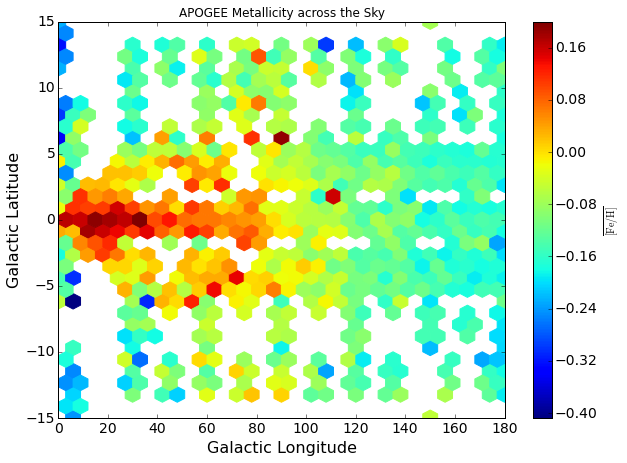

In [35]:
plt.figure()
plt.hexbin(goodPlaneStar['GLON'], goodPlaneStar['GLAT'], C=goodPlaneStar['FE_H'], 
           gridsize=30, mincnt=2)
#hexbin plots mean of 'C' array
plt.xlabel('Galactic Longitude', fontsize=16)
plt.ylabel('Galactic Latitude', fontsize=16)
cb = plt.colorbar(label=r'$\overline{[\mathrm{Fe/H}]}$')
plt.title('APOGEE Metallicity across the Sky')

Awesome! We now see the metallicity of the central region of the Galaxy as a function of position. **Comment on metallicity gradient** *TODO SOON*

# 11 Plot: Metallicity vs. RV for Quadrant 2 Stars

Once you get a feel for this workflow, you can quickly make plots using tens of thousands of stars. To make a plot showing the radial velocity and metallicity of all stars that are in quadrant 2:

- Define the spatial region of interest
- Ensure the metallicity determination is robust as we did for the Galactic plane sample above
- Make the plot using stars that meet the above criteria

In [36]:
#Quadrant 2 is 90 < GLON < 180
quadrant2 = np.logical_and(mainStar['GLON']>90, mainStar['GLON']<180)

We can reuse `feh_robust` from Section 10 to quickly focus on the sample we want.

In [37]:
# Using the feh_robust boolean array from Section 10
goodQuadrant2 = mainStar[np.logical_and(quadrant2,feh_robust)]

`goodQuadrant2` now refers to stars with good FeH determination and in quadrant 2.

In [38]:
print('{0} stars are "quadrant2" with robust [Fe/H] determination'.format(goodQuadrant2.shape[0]))

28455 stars are "quadrant2" with robust [Fe/H] determination


Now let's make a scatter plot of [Fe/H] vs. line-of-sight velocity for stars in `goodQuadrant2`

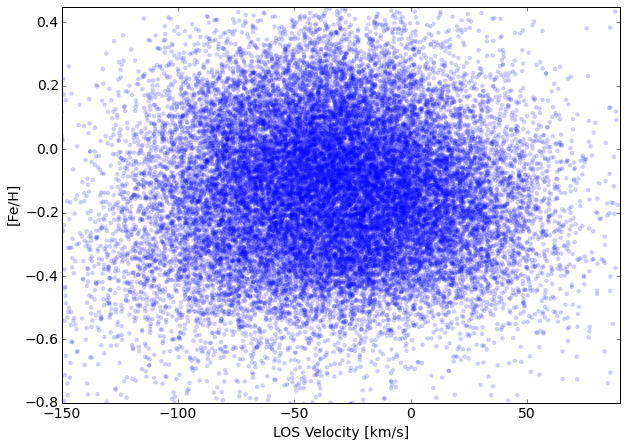

In [39]:
plt.figure()
plt.scatter(goodQuadrant2['VHELIO_AVG'], goodQuadrant2['FE_H'], edgecolor='none', alpha=0.2)
#see http://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.scatter for scatter options
plt.xlim(-150,90) # limiting the range of the x-axis
plt.ylim(-0.8,0.45) # limiting the range of the y-axis
plt.xlabel('LOS Velocity [km/s]', fontsize=14)
plt.ylabel('[Fe/H]', fontsize=14)


# 12 The Red Clump Catalog

The DR12 APOGEE Red Clump Catalog [Bovy et al. (2014)](http://adsabs.harvard.edu/abs/2014ApJ...790..127B) contains 19,937 red clump stars (vs. 10,341 in the original version of the catalog) with precise distance measurements. The catalog paper's abstract reads

>The Sloan Digital Sky Survey III's Apache Point Observatory Galactic Evolution Experiment (APOGEE) is a high-resolution near-infrared spectroscopic survey covering all of the major components of the Galaxy, including the dust-obscured regions of the inner Milky Way disk and bulge. Here we present a sample of 10,341 likely red-clump stars (RC) from the first two years of APOGEE operations, selected based on their position in color-metallicity-surface-gravity-effective-temperature space using a new method calibrated using stellar-evolution models and high-quality asteroseismology data. The narrowness of the RC locus in color-metallicity-luminosity space allows us to assign distances to the stars with an accuracy of 5 to 10%. The sample extends to typical distances of about 3 kpc from the Sun, with some stars out to 8 kpc, and spans a volume of approximately 100 kpc^3 over 5 kpc <~ R <~ 14 kpc, |Z| <~ 2 kpc, and -15 deg <~ Galactocentric azimuth <~ 30 deg. The APOGEE red-clump (APOGEE-RC) catalog contains photometry from 2MASS, reddening estimates, distances, line-of-sight velocities, stellar parameters and elemental abundances determined from the high-resolution APOGEE spectra, and matches to major proper motion catalogs. We determine the survey selection function for this data set and discuss how the RC selection samples the underlying stellar populations. We use this sample to limit any azimuthal variations in the median metallicity within the ~45 degree-wide azimuthal region covered by the current sample to be <= 0.02 dex, which is more than an order of magnitude smaller than the radial metallicity gradient. This result constrains coherent non-axisymmetric flows within a few kpc from the Sun.  
`-` [Bovy et al. (2014)](http://adsabs.harvard.edu/abs/2014ApJ...790..127BD)

## 12.1 Getting the Data
  **Option 1**: Directly download the RC catalog file [HERE](http://data.sdss3.org/sas/dr12/apogee/vac/apogee-rc/cat/apogee-rc-DR12.fits). Once the catalog is downloaded, move the file  into the path assigned to the `data_directory` variable in Section 6.2.
  
  **Option 2**: Automatic Download. As you run the code, it will search for the *apogee-rc-DR12.fits* file in the path assigned to `data_directory`. If it is not found, the catalog will be downloaded.

## 12.1 Reading the RC Catalog

In [40]:
#Make sure the urllib module has been imported and geturl_func has been defined!

rc_file = 'apogee-rc-DR12.fits'
RCstar_localpath = os.path.join(data_directory,rc_file)

RCstar_file_link = 'http://data.sdss3.org/sas/dr12/apogee/vac/apogee-rc/cat/apogee-rc-DR12.fits'
#Download allStar file if it does not exist
if not os.path.exists(RCstar_localpath):
    geturl_func(RCstar_file_link, filename=RCstar_localpath, reporthook=report)

allRC_fits = pyfits.open(RCstar_localpath)
allRC = allRC_fits[1].data #Takes data is HDU 1 and assigns it to allStar

## 12.3 Red Clump Data Model

All available data for the Red Clump sample is described by the data model at http://data.sdss3.org/datamodel/files/APOGEE_RC/cat/apogee-rc-DR12.html.
Some interesting additional data fields available for RC stars:

| Field     | dtype | Units     |Description                                                |
|-----      |-----  | -----     |------------                                               |
|RC_DIST	|float64|	kpc 	|Distance                                                   |
|RC_DM	    |float64|	    	|Distance modulus                                           |
|RC_GALR	|float64|	kpc 	|Galactocentric distance assuming R0 = 8 kpc, Z0 = 25 pc    |
|RC_GALPHI	|float64|	radians	|Galactocentric azimuth assuming R0 = 8 kpc, Z0 = 25 pc     |
|RC_GALZ	|float64|	kpc 	|Distance from the mid-plane assuming R0 = 8 kpc, Z0 = 25 pc|




## 12.4 Plot: [$\alpha$/Fe] vs. [Fe/H] for annulus of stars
We can use the precise distances of RC stars to probe particular regions of the galaxy. For example, let's examine the [$\alpha$/Fe] vs. [Fe/H] plane for stars with $6 < R_{\mathrm{GC}} < 8$ kpc and $|z_{\mathrm{GC}}| < 1$ kpc.

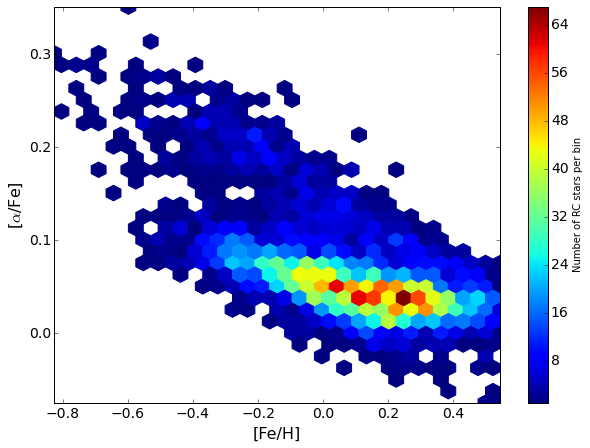

In [41]:
#define the spatial region of interest
annulus_r6_r8 = np.logical_and(allRC['RC_GALR']>6, allRC['RC_GALR']<8)
close_to_plane = np.abs(allRC['RC_GALZ'])<1.0

inplane_annulus = np.logical_and(annulus_r6_r8, close_to_plane)#annulusRCPlaneStars

annulusRC = allRC[inplane_annulus]

plt.hexbin(annulusRC['METALS'], annulusRC['ALPHAFE'], gridsize=30, mincnt=1)

#'METALS' is technically [Z/H], but for our purposes, it is akin to [Fe/H]
plt.xlabel('[Fe/H]', fontsize=16)
plt.ylabel(r'[$\alpha$/Fe]', fontsize=16)
cb = plt.colorbar(label='Number of RC stars per bin')


## Individual Spectrum plotting

need locationID and APOGEE_ID. mention dir_structure aspcap_run, reduction_run, version #, http://www.sdss.org/dr12/irspec/spectra/

APOGEE_REDUX/APRED_VERS/APSTAR_VERS/ASPCAP_VERS/RESULTS_VERS/LOCATION_ID; see datamodel)

http://data.sdss3.org/datamodel/files/APOGEE_REDUX/APRED_VERS/APSTAR_VERS/ASPCAP_VERS/RESULTS_VERS/LOCATION_ID/aspcapStar.html

http://www.sdss.org/dr12/irspec/spectro_data/

todo: description, prettier plot of spectrum and model, show full wavelength coverage.

In [42]:
indx = 17301
locID = mainStar['LOCATION_ID'][indx]
apoID = mainStar['APOGEE_ID'][indx]
spectra_link = 'http://data.sdss3.org/sas/dr12/apogee/spectro/redux/r5/stars/l25_6d/v603/{0}/aspcapStar-r5-v603-{1}.fits'.format(locID,apoID)
spectra_filename = 'aspcapStar-r5-v603-{0}.fits'.format(apoID)
localspectralpath = os.path.join(data_directory,spectra_filename)
if not os.path.exists(localspectralpath):
    geturl_func(spectra_link, filename=localspectralpath)


In [43]:
apogeeSpectrum = pyfits.open(localspectralpath)
flux = apogeeSpectrum[1].data # flux
model = apogeeSpectrum[3].data # best fit spectrum
error = apogeeSpectrum[2].data # this is the error array␣
nlam = len(apogeeSpectrum[1].data)

In [44]:
start_wl =  apogeeSpectrum[1].header['CRVAL1']
diff_wl = apogeeSpectrum[1].header['CDELT1']
val = diff_wl*(nlam) + start_wl
wl_full_log = np.arange(start_wl,val, diff_wl)
wl_full = [10**aval for aval in wl_full_log]
SNR = apogeeSpectrum[0].header['SNR']

(15200, 15700)

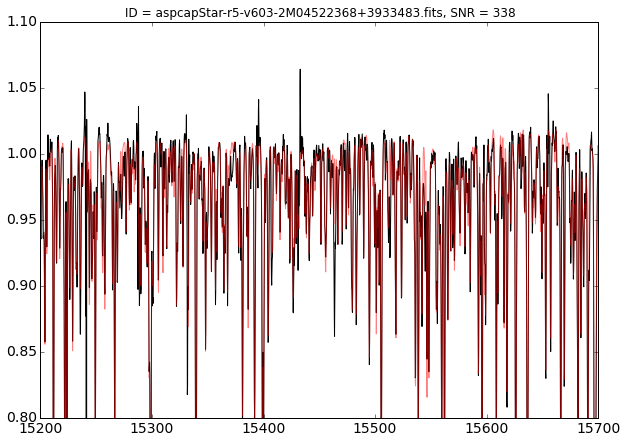

In [45]:
plt.figure()
plt.plot(wl_full, flux, color = 'k', label='Data')
plt.plot(wl_full, model, color = 'red',alpha=0.5, label='Model')
plt.title("ID = "+str(spectra_filename)+", SNR = "+str(np.int(SNR)), fontsize = 12) 
plt.ylim(0.8,1.1)
plt.xlim(15200,15700)

###Finished! Cells below are notes/snippets for me until next week

Nidever + 
other papers

Optional:

  + APOGEE module [[https://github.com/jobovy/apogee]] Jo Bovy has
    written an excellent python module designed to interact and
    manipulate APOGEE data. It simplifies many of the basic operations
    we will cover below and also provides more advanced tools for
    dealing with individual APOGEE spectra. Highly recommended!


In [ ]:
#### Option 2: `APOGEE`


#We refer the user to [[https://github.com/jobovy/apogee]] for
#  installation instuctions and assume you have a working install in the
#  remainder of the notebook.
os.environ['APOGEE_DATA'] = data_directory
os.environ['APOGEE_REDUX'] = 'v603' #DR12 reduction version

import apogee.tools.read as apread
allStar= apread.allStar()  #will automatically download if catalog not available
print ("AllStar file Loaded")


In [ ]:
## 12.2 `apogee`  option (if running the cell below, you must have SKIPPED the `pyfits` module option above)
os.environ['APOGEE_DATA'] = data_directory
os.environ['APOGEE_REDUX'] = 'v603' #DR12 reduction version

import apogee.tools.read as apread
allRC= apread.rcsample()  #will automatically download if catalog not available
print ("Red Clump catalog file Loaded")
